In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import math
from UnarySim.sw.stream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.kernel.add import GainesAdd
from UnarySim.sw.metric.metric import ProgressiveError, NormStability
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import time
import math
import numpy as np

In [3]:
import torch
from UnarySim.sw.kernel.shiftreg import ShiftReg
from UnarySim.sw.stream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.kernel.add import GainesAdd
from UnarySim.sw.kernel.abs import UnaryAbs
from UnarySim.sw.metric.metric import ProgressiveError


class UnaryEdgeDetect(torch.nn.Module):
    """
    this module is a unary based implementation of Robert's cross operator. Reference to "Using Stochastic Computing to Implement DigitalImage Processing Algorithms."
    """
    def __init__(self,  
                 rng="Sobol",
                 rng_width=1,
                 rng_dim=4,
                 rtype=torch.float,
                 btype=torch.float, 
                 stype=torch.float):
        super(UnaryEdgeDetect, self).__init__()

        self.bitwidth = rng_width
        self.rng_dim = rng_dim
        self.rng = "Sobol"
        self.rtype = rtype
        self.btype = btype
        self.stype = stype

        self.Gx_sub = GainesAdd(mode="bipolar", 
                 scaled=True, 
                 acc_dim=0, 
                 rng=self.rng, 
                 rng_dim=self.rng_dim, 
                 rng_width=1, 
                 rtype=self.rtype, 
                 stype=torch.float)

        self.Gy_sub = GainesAdd(mode="bipolar", 
                 scaled=True, 
                 acc_dim=0, 
                 rng=self.rng, 
                 rng_dim=self.rng_dim+4, 
                 rng_width=1, 
                 rtype=self.rtype, 
                 stype=torch.float)

        self.G_add = GainesAdd(mode="bipolar", 
                scaled=True, 
                acc_dim=0, 
                rng=self.rng, 
                rng_dim=self.rng_dim+8, 
                rng_width=1, 
                rtype=self.rtype, 
                stype=torch.float)

        self.GxAbs = UnaryAbs(depth=8, shiftreg=False, interleave = False, stype=self.stype, btype=self.btype)
        self.GyAbs = UnaryAbs(depth=8, shiftreg=False, interleave = False, stype=self.stype, btype=self.btype)

        self.Gx=0
        self.Gy=0
        self.Gx_abs=0
        self.Gy_abs=0

        
    def forward(self, inp_Pr_i_j, inp_Pr_i1_j1, inp_Pr_i1_j, inp_Pr_i_j1):

        Pr_i_j = inp_Pr_i_j.type(self.stype)
        Pr_i1_j1 = inp_Pr_i1_j1.type(self.stype)
        Pr_i1_j = inp_Pr_i1_j.type(self.stype)
        Pr_i_j1 = inp_Pr_i_j1.type(self.stype)

        Gx_inp = torch.stack([Pr_i_j,1-Pr_i1_j1],0)
        Gy_inp = torch.stack([Pr_i_j1,1-Pr_i1_j],0)

        self.Gx = self.Gx_sub(Gx_inp)
        self.Gy = self.Gy_sub(Gy_inp)

        self.Gx_abs = self.GxAbs(self.Gx)[1]
        self.Gy_abs = self.GyAbs(self.Gy)[1]

        G_inp = torch.stack([self.Gx_abs,self.Gy_abs],0)

        Ps_i_j = self.G_add(G_inp)

        output = Ps_i_j

        return output.type(self.stype)


--- 13.586011409759521 seconds ---

avg I NS:0.9651
max I NS:1.0
min I NS:0.9299

avg layer1 NS:0.9508
max layer1 NS:0.9844
min layer1 NS:0.8994

avg layer2 NS:0.8359
max layer2 NS:0.9814
min layer2 NS:0.0

avg O NS:0.8098
max O NS:0.9814
min O NS:0.0



[1.0223286, 0.4258351, 0.6246663, 0.2240819, 0.20504688, 0.2798688, 0.2189681, 0.21095917, 0.118253395, 0.100809515, 0.18318887, 0.08733885, 0.09110202, 0.080927685, 0.108403355, 0.07176313, 0.07298744, 0.08919131, 0.13697821, 0.08213361, 0.058928803, 0.07087577, 0.08116415, 0.06560997, 0.057502598, 0.07338535, 0.10752004, 0.0694681, 0.071772926, 0.056770477, 0.07934199, 0.05388395, 0.06513336, 0.064099304, 0.09027253, 0.061523754, 0.04572376, 0.0460777, 0.056228187, 0.04425575, 0.04130415, 0.05267299, 0.07376966, 0.051030677, 0.0397116, 0.039295748, 0.047765527, 0.037993144, 0.038671818, 0.04714609, 0.062029805, 0.045926064, 0.038105134, 0.04364246, 0.046948172, 0.04235556, 0.038196426, 0.04476362, 0.05779965, 0.043800175, 0.044058926, 0.034067314, 0.04331367, 0.033322707, 0.041967474, 0.04071243, 0.051896412, 0.039964855, 0.03543371, 0.03639311, 0.03956792, 0.035629038, 0.034151115, 0.037752576, 0.047694165, 0.03715184, 0.032348312, 0.031140896, 0.03555448, 0.030581087, 0.03161731, 0

RMSE:0.06766
MAE: 0.0258
bias:-0.02194
max: 0.1799
min: -0.7867


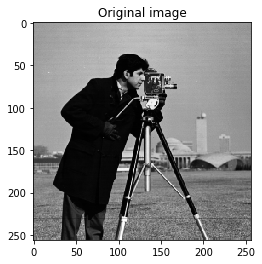

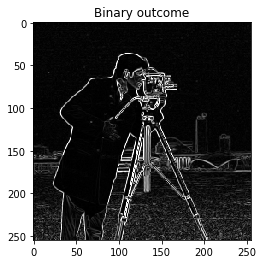

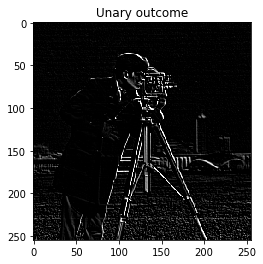

In [4]:
im = Image.open("cameraman.png")

im = im.convert("L") 
data = im.getdata()
data = np.matrix(data)
data = np.reshape(data,(256,256))

bitwidth = 10
mode = "bipolar"
btype = torch.int8
rtype=torch.float
stype=torch.int8
rng = "Sobol"

device = "cpu"

# data generation, divide the whole image into four overlapping 255*255 windows
inp_Pr_i_j = torch.tensor(data[0:255,0:255]).type(torch.float)
inp_Pr_i1_j1 = torch.tensor(data[1:256,1:256]).type(torch.float)
inp_Pr_i1_j = torch.tensor(data[1:256,0:255]).type(torch.float)
inp_Pr_i_j1 = torch.tensor(data[0:255,1:256]).type(torch.float)

# Calculation in parellel, save data in B_output, and Bdata is for image plotting
Gx = inp_Pr_i_j - inp_Pr_i1_j1
Gy = inp_Pr_i_j1 - inp_Pr_i1_j
Gx_abs = torch.abs(Gx)
Gy_abs = torch.abs(Gy)
B_output = (Gx_abs + Gy_abs)
Bdata = (B_output).numpy()   

input = torch.stack([(inp_Pr_i_j/255), (inp_Pr_i1_j1/255), (inp_Pr_i1_j/255),(inp_Pr_i_j1/255)],0)

inputSRC = SourceGen(prob=input, bitwidth=bitwidth, mode=mode, rtype=rtype)().to(device)
inputRNG = RNG(bitwidth=bitwidth, dim=1, rng=rng, rtype=rtype)().to(device)
inputBS = BSGen(source=inputSRC, rng_seq=inputRNG, stype=stype).to(device)


Ued = UnaryEdgeDetect(rng=rng,rng_width=1,rng_dim=4,rtype=rtype,btype=btype,stype=stype).to(device)

inputPE  = ProgressiveError(in_value=input, mode=mode).to(device)
outputPE = ProgressiveError(in_value=(B_output.type(torch.float))/255/4, mode=mode).to(device)

inijNs = NormStability(in_value=inp_Pr_i_j/255, mode="bipolar", threshold=0.05).to(device)
ini1j1Ns = NormStability(in_value=inp_Pr_i1_j1/255, mode="bipolar", threshold=0.05).to(device)
ini1jNs = NormStability(in_value=inp_Pr_i1_j/255, mode="bipolar", threshold=0.05).to(device)
inij1Ns = NormStability(in_value=inp_Pr_i_j1/255, mode="bipolar", threshold=0.05).to(device)
GxNS = NormStability(in_value=Gx/2/255, mode="bipolar", threshold=0.05).to(device)
GyNS = NormStability(in_value=Gy/2/255, mode="bipolar", threshold=0.05).to(device)
GxabsNS = NormStability(in_value=Gx_abs/2/255, mode="bipolar", threshold=0.05).to(device)
GyabsNS = NormStability(in_value=Gy_abs/2/255, mode="bipolar", threshold=0.05).to(device)
GNS = NormStability(in_value=B_output/4/255, mode="bipolar", threshold=0.05).to(device)

result_pe_cycle = []
with torch.no_grad():
    start_time = time.time()
    for i in range(2**bitwidth):

        input_bs = inputBS(torch.tensor([i]))
        inputPE.Monitor(input_bs)
        
        inijNs.Monitor(input_bs[0])
        ini1j1Ns.Monitor(input_bs[1])
        ini1jNs.Monitor(input_bs[2])
        inij1Ns.Monitor(input_bs[3])
        
        output_bs = Ued(input_bs[0], input_bs[1], input_bs[2], input_bs[3])
        
        GxNS.Monitor(Ued.Gx)
        GyNS.Monitor(Ued.Gy)
        GxabsNS.Monitor(Ued.Gx_abs)
        GyabsNS.Monitor(Ued.Gy_abs)
        
        GNS.Monitor(output_bs)
        outputPE.Monitor(output_bs)
        
        Udata, result_pe = outputPE()
        Udata = (Udata*255*4).cpu().numpy()
        result_pe = result_pe.cpu().numpy()

        result_pe_cycle.append(np.mean(np.abs(result_pe)))
        
    input_Pij_ns = inijNs()
    input_Pi1j1_ns = ini1j1Ns()
    input_Pi1j_ns = ini1jNs()
    input_Pij1_ns = inij1Ns()
    input_ns = (input_Pij_ns + input_Pi1j1_ns + input_Pi1j_ns + input_Pij1_ns)/4
    
    Gx_ns = GxNS()
    Gy_ns = GyNS()
    after_adder1_ns = (Gx_ns + Gy_ns)/2
    
    Gx_abs_ns = GxabsNS()
    Gy_abs_ns = GyabsNS()
    after_abs_ns = (Gx_abs_ns + Gy_abs_ns)/2
    
    output_ns = GNS()
    
    input_ns = input_ns.cpu().numpy()
    after_adder1_ns = after_adder1_ns.cpu().numpy()
    after_abs_ns = after_abs_ns.cpu().numpy()
    output_ns = output_ns.cpu().numpy()
    
    print("--- %s seconds ---" % (time.time() - start_time))
    print()
    
    print("avg I NS:{:1.4}".format(np.mean(input_ns)))
    print("max I NS:{:1.4}".format(np.max(input_ns)))
    print("min I NS:{:1.4}".format(np.min(input_ns)))
    print()
    
    print("avg layer1 NS:{:1.4}".format(np.mean(after_adder1_ns)))
    print("max layer1 NS:{:1.4}".format(np.max(after_adder1_ns)))
    print("min layer1 NS:{:1.4}".format(np.min(after_adder1_ns)))
    print()
    
    print("avg layer2 NS:{:1.4}".format(np.mean(after_abs_ns)))
    print("max layer2 NS:{:1.4}".format(np.max(after_abs_ns)))
    print("min layer2 NS:{:1.4}".format(np.min(after_abs_ns)))
    print()
    
    print("avg O NS:{:1.4}".format(np.mean(output_ns)))
    print("max O NS:{:1.4}".format(np.max(output_ns)))
    print("min O NS:{:1.4}".format(np.min(output_ns)))
    print()

    print(result_pe_cycle)

print("RMSE:{:1.4}".format(np.sqrt(np.mean(result_pe**2))))
print("MAE: {:1.4}".format(np.mean(np.abs(result_pe))))
print("bias:{:1.4}".format(np.mean(result_pe)))
print("max: {:1.4}".format(np.max(result_pe)))
print("min: {:1.4}".format(np.min(result_pe)))

image_u = Image.fromarray(Udata)
image_b = Image.fromarray(Bdata)

plt.figure()
plt.imshow(im,cmap='gray')
plt.title("Original image")

plt.figure()
plt.imshow(image_b)
plt.title("Binary outcome")

plt.figure()
plt.imshow(image_u)
plt.title("Unary outcome");

# im.show()
# image_u.show()
# image_b.show()